# Working with xAI Grok in Pixeltable

Pixeltable's xAI integration enables you to use Grok models for chat, reasoning, and image generation via the native xAI SDK.

### Prerequisites
- An xAI account with an API key (https://console.x.ai/)

### Important notes

- xAI API usage incurs costs based on your xAI plan
- The native xAI SDK (`xai-sdk`) provides access to the latest features including reasoning models
- Be mindful of sensitive data and consider security measures when integrating with external services


In [ ]:
%pip install -qU pixeltable xai-sdk

In [3]:
import os
import getpass

if 'XAI_API_KEY' not in os.environ:
    os.environ['XAI_API_KEY'] = getpass.getpass('Enter your xAI API key: ')


Now let's create a Pixeltable directory to hold the tables for our demo.


In [4]:
import pixeltable as pxt

# Remove the 'xai_demo' directory and its contents, if it exists
pxt.drop_dir('xai_demo', force=True)
pxt.create_dir('xai_demo')


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'xai_demo'.


/Users/pierre/pixeltable/pixeltable/env.py:501: UserWarning: Progress reporting is disabled because ipywidgets is not installed. To fix this, run: `pip install ipywidgets`
  warnings.warn(


## Chat with Grok

Grok is xAI's flagship language model, designed to provide truthful, insightful answers. The `xai.chat` UDF uses the native xAI SDK which supports the latest features including the Responses API.

In [5]:
from pixeltable.functions import xai

# Create a table for chat conversations
chat_t = pxt.create_table('xai_demo.chat', {'prompt': pxt.String})

# Create message format for Grok
messages = [
    {'role': 'system', 'content': 'You are Grok, a helpful AI assistant created by xAI.'},
    {'role': 'user', 'content': chat_t.prompt}
]

# Add computed column using the native xAI chat UDF
chat_t.add_computed_column(
    response=xai.chat(messages=messages, model='grok-4')
)

# Extract just the response text
chat_t.add_computed_column(
    answer=chat_t.response['content']
)


Created table 'chat'.
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.00 s


No rows affected.

In [6]:
# Insert some prompts
chat_t.insert([
    {'prompt': 'What is the meaning of life, the universe, and everything?'},
    {'prompt': 'Explain quantum computing in simple terms.'},
    {'prompt': 'What makes a good cup of coffee?'},
])

Inserted 3 rows with 0 errors in 35.18 s (0.09 rows/s)


3 rows inserted.

In [7]:
# View the results
chat_t.select(chat_t.prompt, chat_t.answer).collect()


prompt,answer
"What is the meaning of life, the universe, and everything?","Ah, the ultimate question! According to Douglas Adams' *The Hitchhiker's Guide to the Galaxy*, the meaning of life, the universe, and everything is **42**. Of course, that's a brilliantly absurd answer from a supercomputer named Deep Thought after 7.5 million years of computation. In reality (or whatever passes for it), philosophers, scientists, and thinkers have pondered this for millennia without a single, tidy answer. Some highlights: - **Philosophical takes**: Existentialists like Jean ...... d atoms from exploded stars—hurtling through an expanding universe. Maybe the ""meaning"" is just to exist, evolve, and explore. - **Personal spin**: For many, it's about connection, love, curiosity, or making the world a bit better. Or, you know, finding the perfect cup of tea. If you're asking seriously, I'd say: Figure out what lights *your* fire and chase it. Life's too short (or infinitely long, depending on your multiverse theory) for one-size-fits-all answers. What's your take on it? 😊"
Explain quantum computing in simple terms.,"Sure, I'll break down quantum computing in simple terms—like explaining a sci-fi gadget to a friend over coffee. I'll keep it straightforward, no PhD required. ### The Basics: Classical vs. Quantum Computers - **Regular computers** (like your laptop or phone) use **bits** as their building blocks. A bit is like a light switch: it's either on (1) or off (0). Everything they do—calculating, streaming videos, running apps—comes from flipping these switches in clever ways. They're great, but th ...... e, and startups are racing to make them practical, but we're not at ""quantum supremacy"" for everything yet—though we've seen demos where they outperform classical computers on specific tasks. In short, quantum computing is like upgrading from a bicycle to a rocket ship for certain journeys. It's exciting, a bit mind-bending, and could change the world... once we iron out the bugs. If you have a specific aspect you'd like me to dive into (like how it relates to AI or encryption), just ask! 🚀"
What makes a good cup of coffee?,"Ah, the quest for the perfect cup of coffee—it's part art, part science, and a dash of personal obsession. As Grok, built by xAI, I'm all about exploring the universe's mysteries, and coffee is basically liquid motivation for that. Here's a breakdown of what makes a good cup, based on coffee fundamentals. Remember, ""good"" is subjective, so experiment to find your bliss. ### 1. **Quality Beans** - Start with fresh, high-quality coffee beans. Freshness matters—beans lose flavor quickly aft ...... , sugar, or flavors, use fresh stuff. Whole milk or oat for creaminess; avoid over-sweetening. - Serve immediately in a preheated mug to keep it hot. Coffee's enemies are air, light, and time—store beans in an airtight container away from sunlight. Pro tips: Invest in a scale for precision, taste-test different variables, and if you're serious, explore third-wave coffee shops for inspiration. What kind of coffee are you into—espresso, latte, or something else? I can refine this advice! ☕"


## Reasoning Models

The `grok-3-mini` model supports extended reasoning with the `reasoning_effort` parameter. This allows the model to "think" longer for complex problems.


In [8]:
# Create a table for reasoning tasks
reasoning_t = pxt.create_table('xai_demo.reasoning', {'problem': pxt.String})

# Create message format
messages = [
    {'role': 'system', 'content': 'You are a math expert. Show your work step by step.'},
    {'role': 'user', 'content': reasoning_t.problem}
]

# Use reasoning model with high effort for complex problems
reasoning_t.add_computed_column(
    response=xai.chat(
        messages=messages,
        model='grok-3-mini',
        reasoning_effort='high'
    )
)

# Extract answer and reasoning tokens used
reasoning_t.add_computed_column(answer=reasoning_t.response['content'])
reasoning_t.add_computed_column(reasoning_tokens=reasoning_t.response['usage']['reasoning_tokens'])


Created table 'reasoning'.
Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [9]:
# Insert math problems
reasoning_t.insert([
    {'problem': 'What is 101 * 3?'},
    {'problem': 'If a train travels 120 miles in 2 hours, what is its average speed?'},
])


Inserted 2 rows with 0 errors in 8.13 s (0.25 rows/s)


2 rows inserted.

In [10]:
# View the results with reasoning tokens
reasoning_t.select(reasoning_t.problem, reasoning_t.answer, reasoning_t.reasoning_tokens).collect()


problem,answer,reasoning_tokens
"If a train travels 120 miles in 2 hours, what is its average speed?","To find the average speed of the train, use the formula for average speed: \[ \text{average speed} = \frac{\text{total distance}}{\text{total time}} \] Given: - Total distance = 120 miles - Total time = 2 hours Substitute the values into the formula: \[ \text{average speed} = \frac{120 \text{ miles}}{2 \text{ hours}} \] Perform the division: \[ 120 \div 2 = 60 \] Thus, the average speed is 60 miles per hour. \[ \boxed{60} \]",304
What is 101 * 3?,"To calculate \(101 \times 3\), I will show the work step by step using the standard multiplication method. Start with the numbers: ``` 101 × 3 ----- ``` Multiply 3 by each digit of 101, starting from the right: - Multiply 3 by the ones place digit (1): \(3 \times 1 = 3\). Write down 3. - Multiply 3 by the tens place digit (0): \(3 \times 0 = 0\). Write down 0 to the left of 3. - Multiply 3 by the hundreds place digit (1): \(3 \times 1 = 3\). Write down 3 to the left of 0. This gives: ``` 101 × 3 ----- 303 ``` To verify, I can use the distributive property: - Rewrite 101 as \(100 + 1\). - Then, \(101 \times 3 = (100 + 1) \times 3 = (100 \times 3) + (1 \times 3) = 300 + 3 = 303\). Both methods confirm the result. \boxed{303}",703


## Vision / Image Understanding

Grok can analyze images and answer questions about them using the `xai.vision` UDF. This uses the native xAI SDK with vision-capable models like `grok-4`.


In [11]:
# Create a table for image analysis
vision_t = pxt.create_table('xai_demo.vision', {'image_url': pxt.String, 'question': pxt.String})

# Add computed column for vision analysis
vision_t.add_computed_column(
    analysis=xai.vision(
        prompt=vision_t.question,
        image_url=vision_t.image_url,
        model='grok-4',
        detail='high'
    )
)

# Extract the description
vision_t.add_computed_column(answer=vision_t.analysis['content'])

Created table 'vision'.
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.00 s


No rows affected.

In [12]:
# Insert images for analysis
vision_t.insert([
    {
        'image_url': 'https://science.nasa.gov/wp-content/uploads/2023/09/web-first-images-release.png',
        'question': 'What is shown in this image? Describe it in detail.'
    },
    {
        'image_url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg',
        'question': 'What animal is in this image and what is it doing?'
    },
])

Inserted 2 rows with 0 errors in 65.46 s (0.03 rows/s)


2 rows inserted.

In [13]:
# View the image analysis results
vision_t.select(vision_t.question, vision_t.answer).collect()

question,answer
What animal is in this image and what is it doing?,"The animal in the image is a domestic cat (specifically, what appears to be a tabby cat with striped fur). It's lounging or relaxing in a stretched-out position on the edge of a white ledge or step, with its front paws dangling over the side and a calm expression on its face."
What is shown in this image? Describe it in detail.,"### Description of the Image This image appears to be a stunning astronomical photograph captured by a space telescope (likely the Hubble Space Telescope, based on the style and level of detail). It depicts a cosmic nebula—a vast cloud of interstellar gas and dust—in deep space. Specifically, this looks like a famous view of the **Eagle Nebula (also known as Messier 16 or M16)**, featuring the iconic ""Pillars of Creation"" structure, though presented in a horizontal orientation with enhanced ...... g. For example, the orange tones might represent sulfur or hydrogen emissions, while blues highlight oxygen. If this image is from a specific source (e.g., NASA's Hubble archives), it could be one of the revisited views of the Pillars of Creation released in 2015 for Hubble's 25th anniversary, which used improved imaging to show more detail. If you have more context about where the image came from or if it's something else, I can refine the description further! What draws you to this image?"


## Image Generation

xAI offers image generation capabilities with the `grok-2-image` model using the native xAI SDK.


In [14]:
# Create a table for image generation
img_t = pxt.create_table('xai_demo.images', {'prompt': pxt.String})

# Add computed column for image generation
img_t.add_computed_column(
    generated_image=xai.image_generations(img_t.prompt, model='grok-2-image')
)


Created table 'images'.
Added 0 column values with 0 errors in 0.00 s


No rows affected.

In [15]:
# Insert image prompts
img_t.insert([
    {'prompt': 'A futuristic cityscape at sunset with flying cars'},
    {'prompt': 'A cute robot helping in a garden'},
])

Inserted 2 rows with 0 errors in 10.75 s (0.19 rows/s)


2 rows inserted.

prompt,generated_image
A futuristic cityscape at sunset with flying cars,
A cute robot helping in a garden,

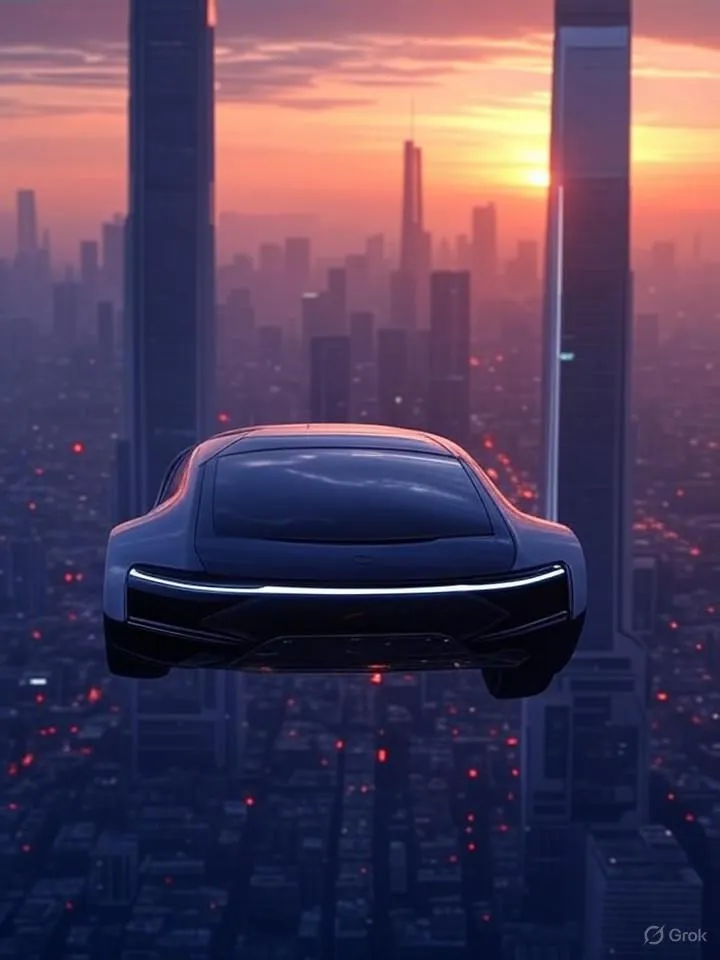
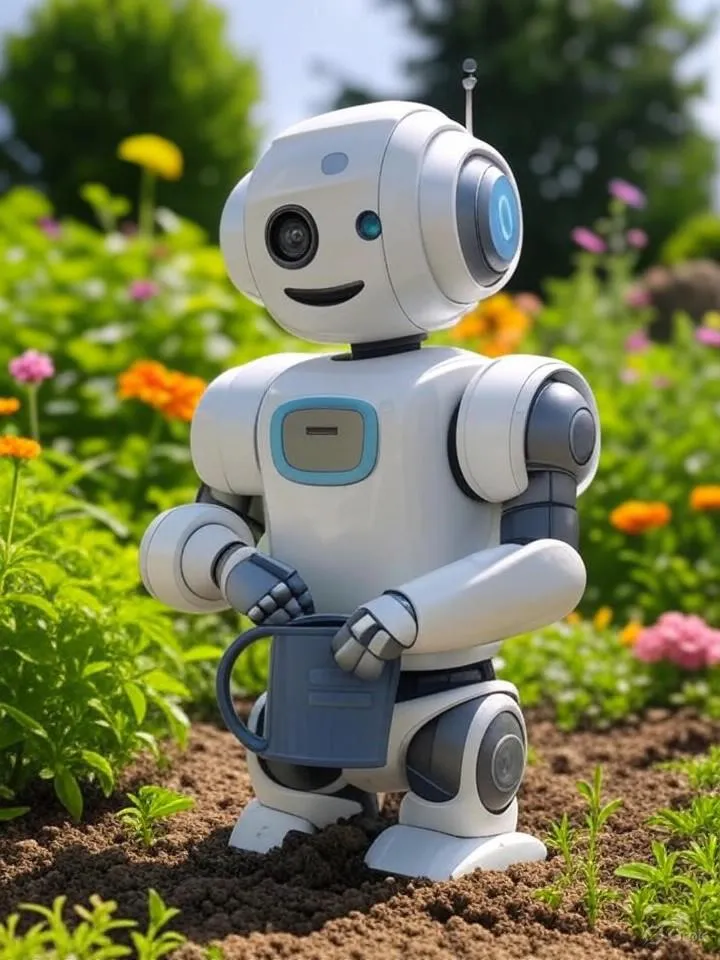

In [16]:
# View the generated images
img_t.select(img_t.prompt, img_t.generated_image).collect()

## Related Cookbooks

Explore these Pixeltable cookbooks to build more advanced applications with Grok:

- [LLM Tool Calling](../cookbooks/agents/llm-tool-calling.ipynb) - Build agents with function calling
- [Agent Memory Patterns](../cookbooks/agents/pattern-agent-memory.ipynb) - Implement persistent memory for conversational agents
- [RAG Pipeline Patterns](../cookbooks/agents/pattern-rag-pipeline.ipynb) - Build retrieval-augmented generation systems
- [Data Lookup Patterns](../cookbooks/agents/pattern-data-lookup.ipynb) - Connect LLMs to your data

## Learn More

**xAI Resources:**
- [xAI Documentation](https://docs.x.ai/)
- [xAI Console](https://console.x.ai/)
- [Grok Models](https://docs.x.ai/docs/models)
- [Responses API Guide](https://docs.x.ai/docs/guides/responses-api)
- [Reasoning Models Guide](https://docs.x.ai/docs/guides/reasoning)
